In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve
from sklearn.model_selection import KFold, RepeatedKFold, train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV 

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
sns.set(font_scale=1.5)
warnings.filterwarnings('ignore')

In [2]:
churn=pd.read_excel("Customer Churn Data.xlsx", sheet_name=1)

In [3]:
# List with all missing value formats
missing_value_formats = ["#","&&&&","NA","+", " ", "@","$","*",]
churn = pd.read_excel("Customer Churn Data.xlsx", sheet_name=1, na_values = missing_value_formats)

In [4]:
# Cleaning the data
churn['Gender'].replace(to_replace = 'F', value = 'Female', inplace = True)
churn['Gender'].replace(to_replace = 'M', value = 'Male', inplace = True)
churn['Payment'].replace(to_replace = 'Cash on Delivery', value = 'COD', inplace = True)
churn['account_segment'].replace(to_replace = 'Regular +', value = 'Regular Plus', inplace = True)
churn['account_segment'].replace(to_replace = 'Super +', value = 'Super Plus', inplace = True)

In [5]:
# Geting unique counts of all Nominal Variables
for column in churn[['Payment', 'Gender', 'account_segment', 'Marital_Status', 'Complain_ly', 'Login_device']]:
    print('\n')
    print(column.upper(),': ',churn[column].nunique())
    print(churn[column].value_counts().sort_values())



PAYMENT :  5
UPI             822
COD            1014
E wallet       1217
Credit Card    3511
Debit Card     4587
Name: Payment, dtype: int64


GENDER :  2
Female    4448
Male      6704
Name: Gender, dtype: int64


ACCOUNT_SEGMENT :  5
Regular          520
Super Plus       818
HNI             1639
Super           4062
Regular Plus    4124
Name: account_segment, dtype: int64


MARITAL_STATUS :  3
Divorced    1668
Single      3520
Married     5860
Name: Marital_Status, dtype: int64


COMPLAIN_LY :  2
1.0    3111
0.0    7792
Name: Complain_ly, dtype: int64


LOGIN_DEVICE :  2
Computer    3018
Mobile      7482
Name: Login_device, dtype: int64


In [6]:
X = churn.drop(['Churn'], axis=1)
y = churn['Churn']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=123,stratify=churn['Churn'])

churn_train = pd.concat([X_train,y_train], axis=1)
churn_test = pd.concat([X_test,y_test], axis=1)

churn_train.to_csv('churn_train.csv',index=False)
churn_test.to_csv('churn_test.csv',index=False)


In [7]:
#Tenure to categorical column (Grouping the data according to years.)
def Tenure_lab(churn_train) :
    
    if churn_train["Tenure"] <= 12 :
        return "Tenure_0-12"
    elif (churn_train["Tenure"] > 12) & (churn_train["Tenure"] <= 24 ):
        return "Tenure_12-24"
    elif (churn_train["Tenure"] > 24) & (churn_train["Tenure"] <= 48) :
        return "Tenure_24-48"
    elif (churn_train["Tenure"] > 48) & (churn_train["Tenure"] <= 60) :
        return "Tenure_48-60"
    elif churn_train["Tenure"] > 60 :
        return "Tenure_gt_60"
churn_train["Tenure_group"] = churn_train.apply(lambda churn_train:Tenure_lab(churn_train), axis = 1)

# remove the Tenure variables and check the train data for the 10 rows 

churn_train = churn_train.drop(['Tenure'], axis=1)

#Tenure to categorical column
def Tenure_lab(churn_test) :
    
    if churn_test["Tenure"] <= 12 :
        return "Tenure_0-12"
    elif (churn_test["Tenure"] > 12) & (churn_test["Tenure"] <= 24 ):
        return "Tenure_12-24"
    elif (churn_test["Tenure"] > 24) & (churn_test["Tenure"] <= 48) :
        return "Tenure_24-48"
    elif (churn_test["Tenure"] > 48) & (churn_test["Tenure"] <= 60) :
        return "Tenure_48-60"
    elif churn_test["Tenure"] > 60 :
        return "Tenure_gt_60"
churn_test["Tenure_group"] = churn_test.apply(lambda churn_test:Tenure_lab(churn_test), axis = 1)

# remove the Tenure variables and check the Test data for the 10 rows 

churn_test = churn_test.drop(['Tenure'], axis=1)

churn_train.head(10)

,AccountID,City_Tier,CC_Contacted_LY,Payment,Gender,Service_Score,Account_user_count,account_segment,CC_Agent_Score,Marital_Status,rev_per_month,Complain_ly,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback,Login_device,Churn,Tenure_group
2095,22095,3.0,34.0,Credit Card,Female,2.0,1.0,Super Plus,1.0,Married,4.0,1.0,18.0,4.0,11.0,233.20,Mobile,0,Tenure_12-24
1875,21875,1.0,6.0,Debit Card,Female,3.0,3.0,HNI,5.0,Married,2.0,0.0,11.0,0.0,7.0,174.12,Mobile,0,Tenure_0-12
9487,29487,3.0,29.0,Credit Card,Male,3.0,6.0,Super,1.0,Married,10.0,1.0,15.0,2.0,3.0,182.40,Mobile,1,Tenure_0-12
5615,25615,1.0,9.0,Debit Card,Male,1.0,5.0,Regular Plus,3.0,Single,4.0,0.0,15.0,1.0,3.0,153.09,Mobile,0,Tenure_12-24
3307,23307,1.0,11.0,Credit Card,Male,3.0,4.0,Super,4.0,Single,11.0,0.0,13.0,2.0,4.0,184.33,Mobile,0,Tenure_12-24
3840,23840,1.0,25.0,Debit Card,Male,3.0,2.0,Super,5.0,Married,3.0,0.0,12.0,1.0,11.0,177.08,Mobile,0,Tenure_0-12
1845,21845,1.0,15.0,Debit Card,Female,3.0,3.0,Super,1.0,Married,2.0,1.0,12.0,1.0,5.0,163.22,Mobile,0,Tenure_0-12
2628,22628,1.0,7.0,Debit Card,Male,2.0,3.0,Regular Plus,1.0,Married,2.0,0.0,11.0,0.0,3.0,120.44,Mobile,0,Tenure_0-12
7249,27249,1.0,12.0,Credit Card,Male,3.0,4.0,Regular Plus,3.0,Single,2.0,0.0,19.0,1.0,0.0,139.30,Mobile,0,Tenure_0-12
11172,31172,1.0,13.0,Credit Card,Male,3.0,4.0,Regular Plus,5.0,Married,6.0,1.0,16.0,3.0,4.0,160.65,Computer,0,Tenure_0-12


In [8]:
# remove the unwanted variables and check the data for the 10 rows 

churn_train = churn_train.drop(['AccountID'], axis=1)
churn_test = churn_test.drop(['AccountID'], axis=1)
churn_train.head(10)

,City_Tier,CC_Contacted_LY,Payment,Gender,Service_Score,Account_user_count,account_segment,CC_Agent_Score,Marital_Status,rev_per_month,Complain_ly,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback,Login_device,Churn,Tenure_group
2095,3.0,34.0,Credit Card,Female,2.0,1.0,Super Plus,1.0,Married,4.0,1.0,18.0,4.0,11.0,233.20,Mobile,0,Tenure_12-24
1875,1.0,6.0,Debit Card,Female,3.0,3.0,HNI,5.0,Married,2.0,0.0,11.0,0.0,7.0,174.12,Mobile,0,Tenure_0-12
9487,3.0,29.0,Credit Card,Male,3.0,6.0,Super,1.0,Married,10.0,1.0,15.0,2.0,3.0,182.40,Mobile,1,Tenure_0-12
5615,1.0,9.0,Debit Card,Male,1.0,5.0,Regular Plus,3.0,Single,4.0,0.0,15.0,1.0,3.0,153.09,Mobile,0,Tenure_12-24
3307,1.0,11.0,Credit Card,Male,3.0,4.0,Super,4.0,Single,11.0,0.0,13.0,2.0,4.0,184.33,Mobile,0,Tenure_12-24
3840,1.0,25.0,Debit Card,Male,3.0,2.0,Super,5.0,Married,3.0,0.0,12.0,1.0,11.0,177.08,Mobile,0,Tenure_0-12
1845,1.0,15.0,Debit Card,Female,3.0,3.0,Super,1.0,Married,2.0,1.0,12.0,1.0,5.0,163.22,Mobile,0,Tenure_0-12
2628,1.0,7.0,Debit Card,Male,2.0,3.0,Regular Plus,1.0,Married,2.0,0.0,11.0,0.0,3.0,120.44,Mobile,0,Tenure_0-12
7249,1.0,12.0,Credit Card,Male,3.0,4.0,Regular Plus,3.0,Single,2.0,0.0,19.0,1.0,0.0,139.30,Mobile,0,Tenure_0-12
11172,1.0,13.0,Credit Card,Male,3.0,4.0,Regular Plus,5.0,Married,6.0,1.0,16.0,3.0,4.0,160.65,Computer,0,Tenure_0-12


In [9]:
#After removal of unwanted variables
print(churn_train.shape)
print(churn_test.shape)

(7544, 18)
(3716, 18)


In [10]:
X_train = churn_train.drop(['Churn'], axis=1)
y_train = churn_train['Churn'] 
X_test = churn_test.drop(['Churn'], axis=1)
y_test = churn_test['Churn']

In [11]:
#Checking for Missing values

def missing_check(X_train):
    total = X_train.isnull().sum().sort_values(ascending=False)   # total number of null values
    percent = (X_train.isnull().sum()/X_train.isnull().count()).sort_values(ascending=False)*100  # percentage of values that are null
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])  # putting the above two together
    return missing_data 

# return the dataframe
missing_check(X_train)


,Total,Percent
rev_per_month,522,6.919406
Login_device,506,6.707317
cashback,312,4.135737
Account_user_count,290,3.844115
Complain_ly,239,3.168081
Day_Since_CC_connect,237,3.141569
Tenure_group,144,1.908802
Marital_Status,138,1.829268
CC_Agent_Score,82,1.086957
Gender,72,0.954401


In [12]:
#Checking for Missing values

def missing_check(X_test):
    total = X_test.isnull().sum().sort_values(ascending=False)   # total number of null values
    percent = (X_test.isnull().sum()/X_test.isnull().count()).sort_values(ascending=False)*100  # percentage of values that are null
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])  # putting the above two together
    return missing_data 

# return the dataframe
missing_check(X_test)


,Total,Percent
rev_per_month,269,7.238967
Login_device,254,6.835307
cashback,161,4.332616
Account_user_count,154,4.144241
Day_Since_CC_connect,121,3.256189
Complain_ly,118,3.175457
Tenure_group,74,1.991389
Marital_Status,74,1.991389
City_Tier,49,1.318622
CC_Contacted_LY,41,1.103337


In [13]:
#Train
for column in X_train[['Payment','Gender','account_segment','Marital_Status','Complain_ly','Login_device','Tenure_group']]:
    X_train[column].fillna(X_train[column].mode()[0], inplace=True)
#Test   
for column in X_test[['Payment','Gender','account_segment','Marital_Status','Complain_ly','Login_device','Tenure_group']]:
    X_test[column].fillna(X_train[column].mode()[0], inplace=True)

In [14]:
#Train
# Converting Object data type into Categorical

for feature in X_train.columns: 
    if X_train[feature].dtype == 'object': 
        print('\n')
        print('feature:',feature)
        print(pd.Categorical(X_train[feature].unique()))
        print(pd.Categorical(X_train[feature].unique()).codes)
        X_train[feature] = pd.Categorical(X_train[feature]).codes
        



feature: Payment
['Credit Card', 'Debit Card', 'E wallet', 'UPI', 'COD']
Categories (5, object): ['COD', 'Credit Card', 'Debit Card', 'E wallet', 'UPI']
[1 2 3 4 0]


feature: Gender
['Female', 'Male']
Categories (2, object): ['Female', 'Male']
[0 1]


feature: account_segment
['Super Plus', 'HNI', 'Super', 'Regular Plus', 'Regular']
Categories (5, object): ['HNI', 'Regular', 'Regular Plus', 'Super', 'Super Plus']
[4 0 3 2 1]


feature: Marital_Status
['Married', 'Single', 'Divorced']
Categories (3, object): ['Divorced', 'Married', 'Single']
[1 2 0]


feature: Login_device
['Mobile', 'Computer']
Categories (2, object): ['Computer', 'Mobile']
[1 0]


feature: Tenure_group
['Tenure_12-24', 'Tenure_0-12', 'Tenure_24-48', 'Tenure_gt_60', 'Tenure_48-60']
Categories (5, object): ['Tenure_0-12', 'Tenure_12-24', 'Tenure_24-48', 'Tenure_48-60', 'Tenure_gt_60']
[1 0 2 4 3]


In [15]:
#Test
# Converting Object data type into Categorical

for feature in X_test.columns: 
    if X_test[feature].dtype == 'object': 
        print('\n')
        print('feature:',feature)
        print(pd.Categorical(X_test[feature].unique()))
        print(pd.Categorical(X_test[feature].unique()).codes)
        X_test[feature] = pd.Categorical(X_test[feature]).codes




feature: Payment
['Credit Card', 'Debit Card', 'COD', 'E wallet', 'UPI']
Categories (5, object): ['COD', 'Credit Card', 'Debit Card', 'E wallet', 'UPI']
[1 2 0 3 4]


feature: Gender
['Female', 'Male']
Categories (2, object): ['Female', 'Male']
[0 1]


feature: account_segment
['Super', 'Regular Plus', 'HNI', 'Super Plus', 'Regular']
Categories (5, object): ['HNI', 'Regular', 'Regular Plus', 'Super', 'Super Plus']
[3 2 0 4 1]


feature: Marital_Status
['Single', 'Married', 'Divorced']
Categories (3, object): ['Divorced', 'Married', 'Single']
[2 1 0]


feature: Login_device
['Mobile', 'Computer']
Categories (2, object): ['Computer', 'Mobile']
[1 0]


feature: Tenure_group
['Tenure_0-12', 'Tenure_12-24', 'Tenure_24-48', 'Tenure_gt_60', 'Tenure_48-60']
Categories (5, object): ['Tenure_0-12', 'Tenure_12-24', 'Tenure_24-48', 'Tenure_48-60', 'Tenure_gt_60']
[0 1 2 4 3]


In [16]:
col_names = ['City_Tier','CC_Contacted_LY','Payment','Gender','Service_Score','Account_user_count','account_segment',
             'CC_Agent_Score','Marital_Status','rev_per_month','Complain_ly','rev_growth_yoy','coupon_used_for_payment',
             'Day_Since_CC_connect','cashback','Login_device','Tenure_group']    
    
from sklearn.impute import KNNImputer
knn=KNNImputer(n_neighbors=5)

# Fitting the data to the imputer object
imputer = knn.fit(X_train)

# Imputing the train data
X_train = pd.DataFrame(imputer.transform(X_train))
X_train.columns=col_names

# Imputing the median data in test data
X_test = pd.DataFrame(imputer.transform(X_test))
X_test.columns=col_names

X_train.head()

,City_Tier,CC_Contacted_LY,Payment,Gender,Service_Score,Account_user_count,account_segment,CC_Agent_Score,Marital_Status,rev_per_month,Complain_ly,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback,Login_device,Tenure_group
0,3.0,34.0,1.0,0.0,2.0,1.0,4.0,1.0,1.0,4.0,1.0,18.0,4.0,11.0,233.20,1.0,1.0
1,1.0,6.0,2.0,0.0,3.0,3.0,0.0,5.0,1.0,2.0,0.0,11.0,0.0,7.0,174.12,1.0,0.0
2,3.0,29.0,1.0,1.0,3.0,6.0,3.0,1.0,1.0,10.0,1.0,15.0,2.0,3.0,182.40,1.0,0.0
3,1.0,9.0,2.0,1.0,1.0,5.0,2.0,3.0,2.0,4.0,0.0,15.0,1.0,3.0,153.09,1.0,1.0
4,1.0,11.0,1.0,1.0,3.0,4.0,3.0,4.0,2.0,11.0,0.0,13.0,2.0,4.0,184.33,1.0,1.0


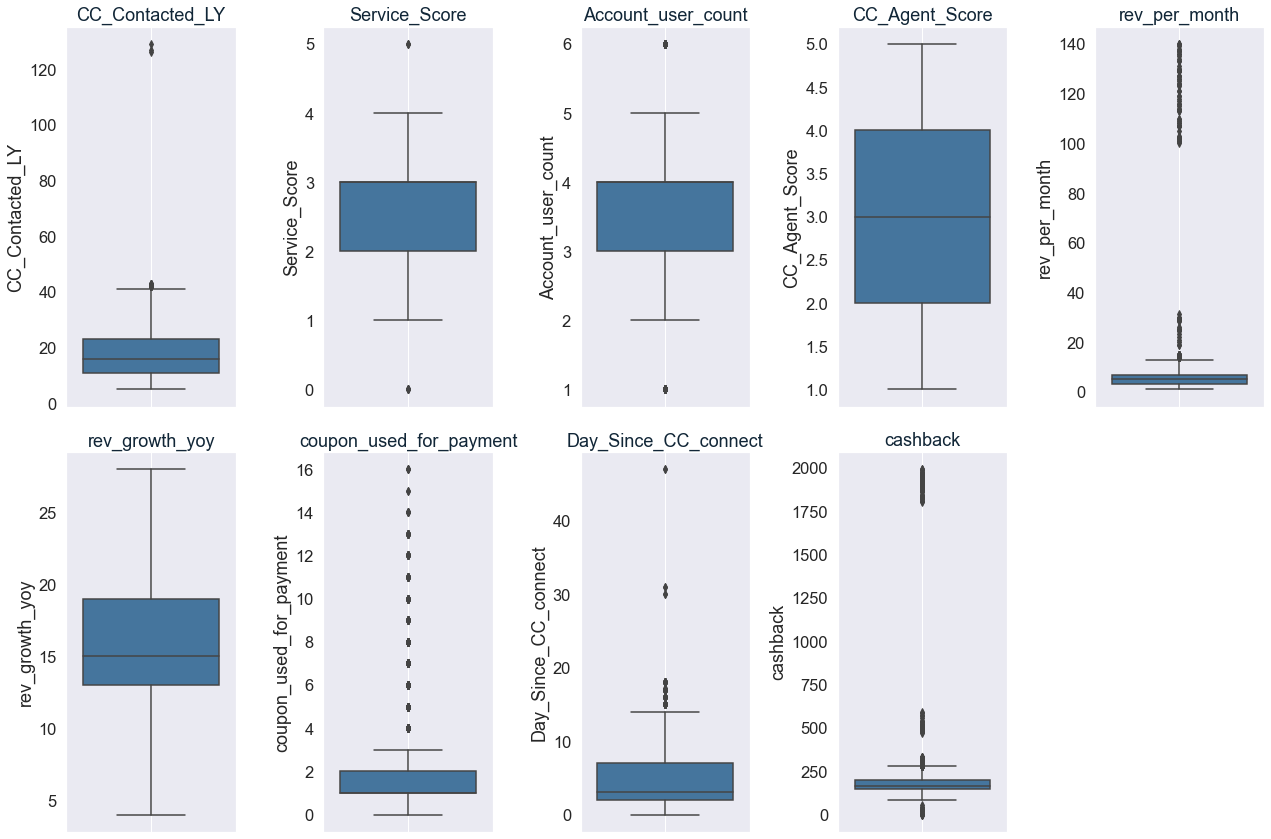

In [17]:
#For Train Data:
continuous = ['CC_Contacted_LY','Service_Score','Account_user_count',
             'CC_Agent_Score','rev_per_month','rev_growth_yoy','coupon_used_for_payment',
             'Day_Since_CC_connect','cashback']    

data_plot=X_train[continuous]

fig=plt.figure(figsize=(18,12))

for i in range(0,len(data_plot.columns)):
    ax=fig.add_subplot(2,5,i+1)
    sns.boxplot(y=data_plot[data_plot.columns[i]],color='#3776ab')
    ax.set_title(data_plot.columns[i],color='#112637')
    plt.grid()

    plt.tight_layout()


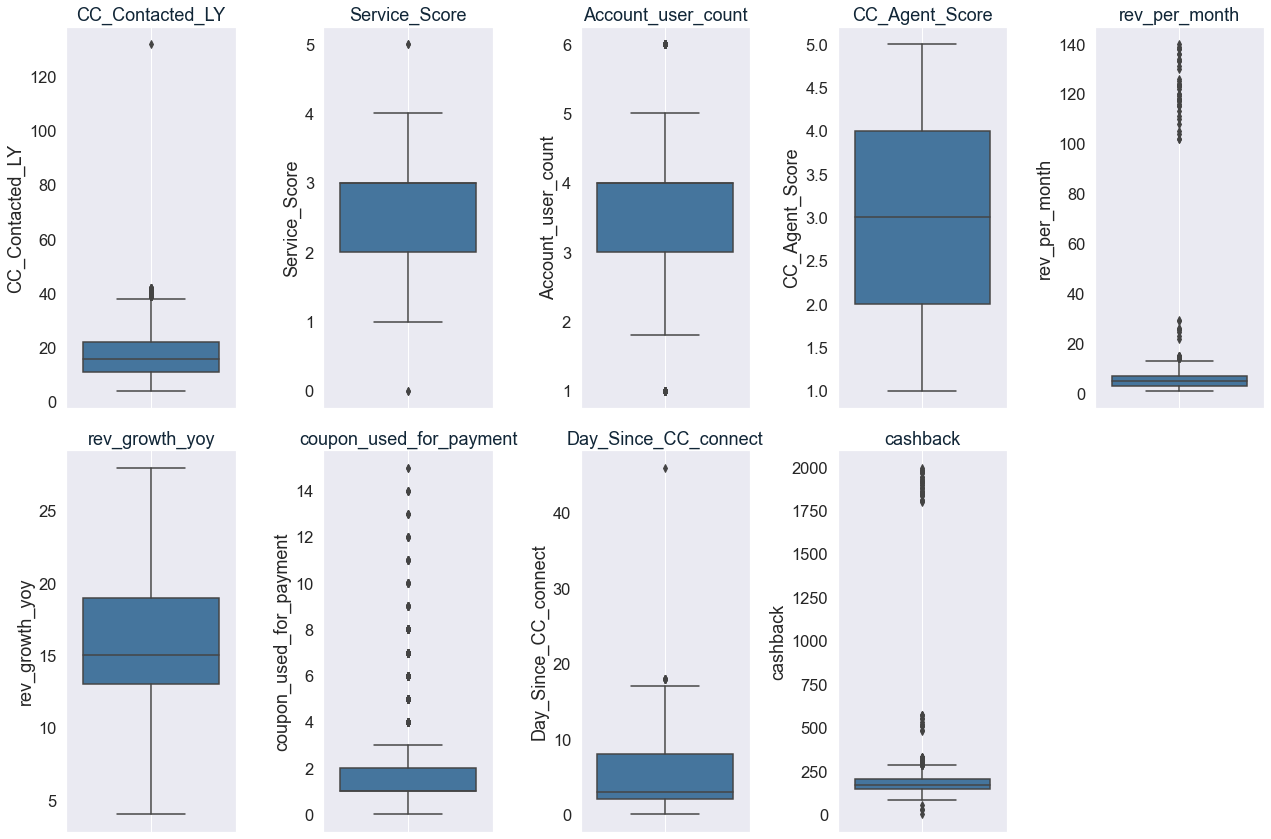

In [18]:
#For Test Data:
data_plot=X_test[continuous]

fig=plt.figure(figsize=(18,12))

for i in range(0,len(data_plot.columns)):
    ax=fig.add_subplot(2,5,i+1)
    sns.boxplot(y=data_plot[data_plot.columns[i]],color='#3776ab')
    ax.set_title(data_plot.columns[i],color='#112637')
    plt.grid()

    plt.tight_layout()

In [19]:
#Capping the outliers

def treat_outlier(x):
    
    # taking 5,25,75 percentile of column
    q5= np.percentile(x,5)
    q25=np.percentile(x,25)
    q75=np.percentile(x,75)
    dt=np.percentile(x,95)
    
    #calculationg IQR range
    IQR=q75-q25
    
    #Calculating minimum threshold
    lower_bound=q25-(1.5*IQR)
    upper_bound=q75+(1.5*IQR)
    
    #Calculating maximum threshold
    print(q5,q25,q75,dt,min,max)
    
    #Capping outliers
    return x.apply(lambda y: dt if y > upper_bound else y).apply(lambda y: q5 if y < lower_bound else y)

In [20]:
for i in X_train:
    X_train[i]=treat_outlier(X_train[i])

1.0 1.0 3.0 3.0 <built-in function min> <built-in function max>
7.0 11.0 23.0 35.0 <built-in function min> <built-in function max>
0.0 1.0 2.0 4.0 <built-in function min> <built-in function max>
0.0 0.0 1.0 1.0 <built-in function min> <built-in function max>
2.0 2.0 3.0 4.0 <built-in function min> <built-in function max>
2.0 3.0 4.0 5.0 <built-in function min> <built-in function max>
0.0 2.0 3.0 4.0 <built-in function min> <built-in function max>
1.0 2.0 4.0 5.0 <built-in function min> <built-in function max>
0.0 1.0 2.0 2.0 <built-in function min> <built-in function max>
2.0 3.0 7.0 11.0 <built-in function min> <built-in function max>
0.0 0.0 1.0 1.0 <built-in function min> <built-in function max>
12.0 13.0 19.0 24.0 <built-in function min> <built-in function max>
0.0 1.0 2.0 6.0 <built-in function min> <built-in function max>
0.0 2.0 7.0 11.0 <built-in function min> <built-in function max>
124.3615 147.07 199.6275 296.87799999999993 <built-in function min> <built-in function max>
0.0

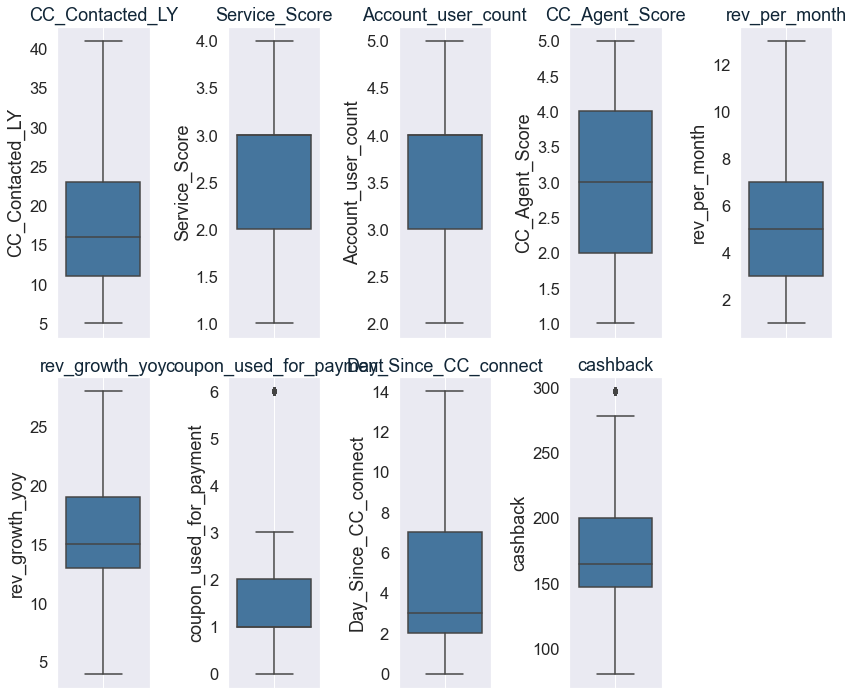

In [21]:
#For Train Data:
data_plot=X_train[continuous]

fig=plt.figure(figsize=(12,10))

for i in range(0,len(data_plot.columns)):
    ax=fig.add_subplot(2,5,i+1)
    sns.boxplot(y=data_plot[data_plot.columns[i]],color='#3776ab')
    ax.set_title(data_plot.columns[i],color='#112637')
    plt.grid()

    plt.tight_layout()

In [22]:
for i in X_train:
    X_test[i]=treat_outlier(X_test[i])

1.0 1.0 3.0 3.0 <built-in function min> <built-in function max>
7.0 11.0 22.0 35.0 <built-in function min> <built-in function max>
0.0 1.0 2.0 4.0 <built-in function min> <built-in function max>
0.0 0.0 1.0 1.0 <built-in function min> <built-in function max>
2.0 2.0 3.0 4.0 <built-in function min> <built-in function max>
2.0 3.0 4.0 5.0 <built-in function min> <built-in function max>
0.0 2.0 3.0 4.0 <built-in function min> <built-in function max>
1.0 2.0 4.0 5.0 <built-in function min> <built-in function max>
0.0 1.0 2.0 2.0 <built-in function min> <built-in function max>
2.0 3.0 7.0 11.0 <built-in function min> <built-in function max>
0.0 0.0 1.0 1.0 <built-in function min> <built-in function max>
11.0 13.0 19.0 23.0 <built-in function min> <built-in function max>
0.0 1.0 2.0 6.0 <built-in function min> <built-in function max>
0.0 2.0 8.0 11.0 <built-in function min> <built-in function max>
124.2025 147.73450000000003 202.0925 297.16499999999996 <built-in function min> <built-in funct

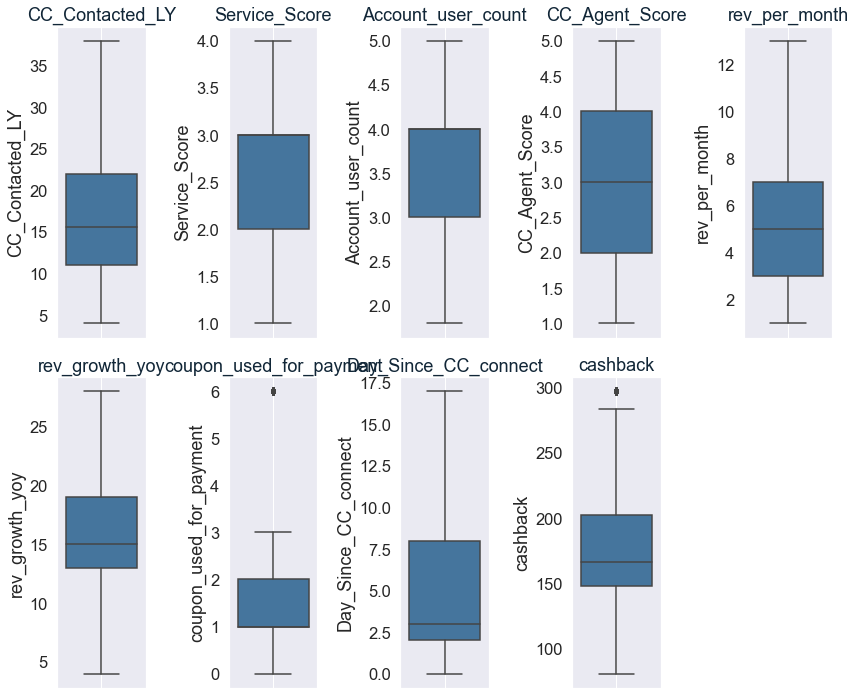

In [23]:
#For Test Data:
data_plot=X_test[continuous]

fig=plt.figure(figsize=(12,10))

for i in range(0,len(data_plot.columns)):
    ax=fig.add_subplot(2,5,i+1)
    sns.boxplot(y=data_plot[data_plot.columns[i]],color='#3776ab')
    ax.set_title(data_plot.columns[i],color='#112637')
    plt.grid()

    plt.tight_layout()

In [24]:
from sklearn.feature_selection import SelectKBest

### Feature Scaling - Standardization:

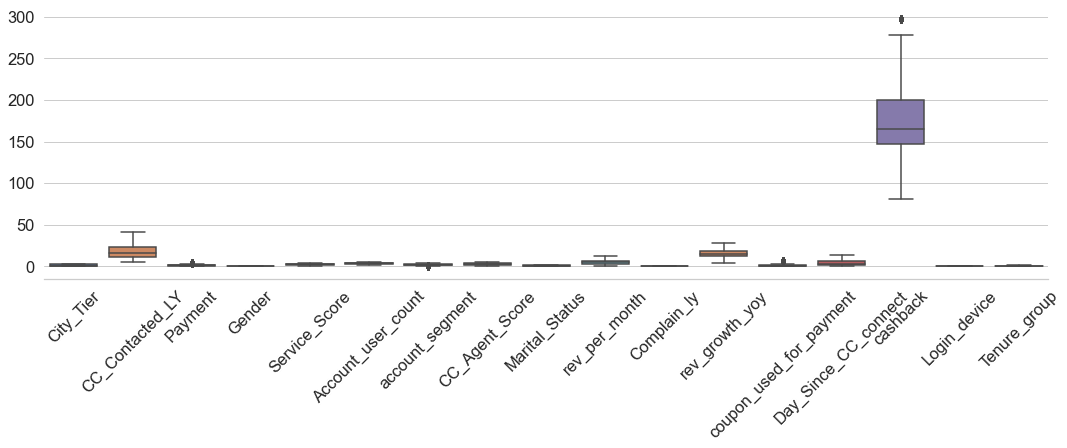

In [25]:
# Before scaling

fig=plt.figure(figsize=(18,5))

sns.set_style("whitegrid")
sns.boxplot(data=X_train,  palette="deep")
plt.xticks(rotation=45)
sns.despine(left=True)

In [26]:
# data standardization with  sklearn
from sklearn.preprocessing import StandardScaler

# copy of datasets
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Numerical features
num_cols = ['Day_Since_CC_connect','cashback']

# apply standardization on numerical features
for i in num_cols:
    
    # fit on training data column
    scale = StandardScaler().fit(X_train_scaled[[i]])
    
    # transform the training data column
    X_train_scaled[i] = scale.transform(X_train_scaled[[i]])
    
    # transform the testing data column
    X_test_scaled[i] = scale.transform(X_test_scaled[[i]])

In [27]:
# copy of datasets
X_train_sc = X_train_scaled.copy()
X_test_sc = X_test_scaled.copy()

### Model Building - Imbalanced data

In [28]:
model = list()
dataset = list()
resample = list()
precision = list()
recall = list()
F1score = list()
Accuracy = list()
AUCROC = list()

In [29]:
def train_eval(clf_model, X_train_sc, y_train, algo=None, sampling=None):
    
    # Test set prediction
    y_prob=clf_model.predict_proba(X_train_sc)
    y_pred=clf_model.predict(X_train_sc)

    print('Classification Report for Train dataset')
    print('='*60)
    print(classification_report(y_train,y_pred),"\n")
    print('AUC-ROC')
    print('='*60)
    print(roc_auc_score(y_train, y_prob[:,1]),"\n")
    
    print('Confusion Matrix')
    print('='*60)
    cf_matrix = confusion_matrix(y_train, y_pred)
    group_names = ['TN','FP','FN','TP']
    group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
          
    model.append(algo)
    precision.append(precision_score(y_train,y_pred))
    recall.append(recall_score(y_train,y_pred))
    F1score.append(f1_score(y_train,y_pred))
    Accuracy.append(accuracy_score(y_train, y_pred))
    AUCROC.append(roc_auc_score(y_train, y_prob[:,1]))
    dataset.append('train')
    resample.append(sampling)
   

In [30]:
def test_eval(clf_model, X_test_sc, y_test, algo=None, sampling=None):
    
    # Test set prediction
    y_prob=clf_model.predict_proba(X_test_sc)
    y_pred=clf_model.predict(X_test_sc)

    print('Classification Report for Test dataset')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    print('AUC-ROC')
    print('='*60)
    print(roc_auc_score(y_test, y_prob[:,1]),"\n")
    
    print('Confusion Matrix')
    print('='*60)
    cf_matrix = confusion_matrix(y_test, y_pred)
    group_names = ['TN','FP','FN','TP']
    group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
          
    model.append(algo)
    precision.append(precision_score(y_test,y_pred))
    recall.append(recall_score(y_test,y_pred))
    F1score.append(f1_score(y_test,y_pred))
    Accuracy.append(accuracy_score(y_test, y_pred))
    AUCROC.append(roc_auc_score(y_test, y_prob[:,1]))
    dataset.append('test')
    resample.append(sampling)

### Model-1: Logistic Regression

In [36]:
# copy of datasets
X_train_sc = X_train_scaled.copy()
X_test_sc = X_test_scaled.copy()

In [37]:
log_model=LogisticRegression()
params={'C':np.logspace(1,10),'class_weight':[None,'balanced'],'penalty':['l1','l2']}

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

# Create random search using 5-fold cross validation
clf_LR = RandomizedSearchCV(log_model, params, cv=cv, scoring='recall', n_jobs=-1)
clf_LR.fit(X_train_sc, y_train)
clf_LR = clf_LR.best_estimator_

In [38]:
clf_LR

LogisticRegression(C=1048.1131341546863, class_weight='balanced')

### b. Any other model tuning measures (if applicable)

### Feature Importance

In [39]:
print (pd.DataFrame(clf_LR.coef_[0], columns = ["Imp"], index = ['City_Tier','CC_Contacted_LY','Payment','Gender',
        'Service_Score','Account_user_count','account_segment','CC_Agent_Score','Marital_Status','rev_per_month','Complain_ly',
        'rev_growth_yoy','coupon_used_for_payment','Day_Since_CC_connect','cashback','Login_device','Tenure_group']    
    ).sort_values('Imp',ascending=False))

                              Imp
Complain_ly              1.540296
Marital_Status           0.513472
Account_user_count       0.362529
City_Tier                0.341649
CC_Agent_Score           0.286120
Gender                   0.252069
coupon_used_for_payment  0.133674
rev_per_month            0.084379
CC_Contacted_LY          0.028846
rev_growth_yoy          -0.034260
Service_Score           -0.092014
Payment                 -0.092837
Login_device            -0.284675
cashback                -0.335583
Day_Since_CC_connect    -0.401111
account_segment         -0.403785
Tenure_group            -1.202421


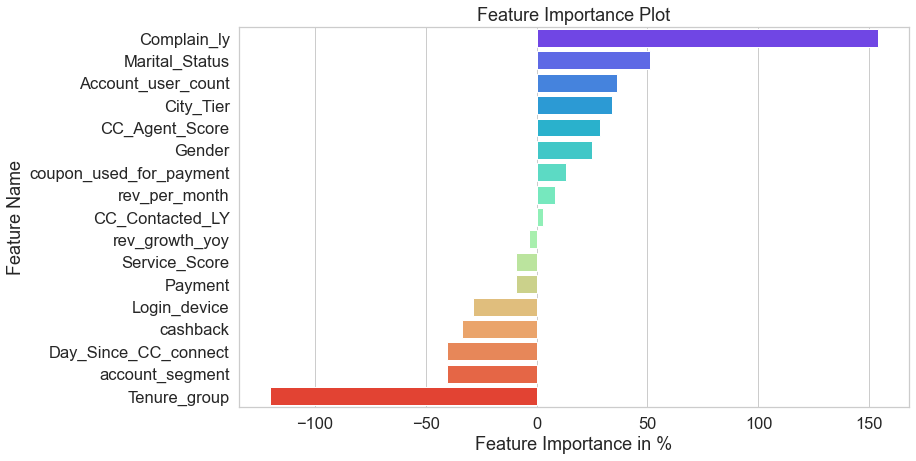

In [40]:
x=pd.DataFrame(clf_LR.coef_[0]*100,index=['City_Tier','CC_Contacted_LY','Payment','Gender',
        'Service_Score','Account_user_count','account_segment','CC_Agent_Score','Marital_Status','rev_per_month','Complain_ly',
        'rev_growth_yoy','coupon_used_for_payment','Day_Since_CC_connect','cashback','Login_device','Tenure_group']).sort_values(by=0,ascending=False)
plt.figure(figsize=(12,7))
sns.barplot(x[0], x.index, palette='rainbow')
plt.ylabel('Feature Name')
plt.xlabel('Feature Importance in %')
plt.title('Feature Importance Plot')
plt.show()

In [41]:
from sklearn.feature_selection import SelectFromModel

# Feature selection

def select_features(X_train_sc, y_train, X_test_sc):

# Select features which have higher contribution in the final prediction

    fs = SelectFromModel(clf_LR, threshold = 0.3, max_features=8) 
    
# learn relationship from training data
    fs.fit(X_train_sc, y_train)

# transform train input data
    X_train_fs = fs.transform(X_train_sc)

# transform test input data
    X_test_fs = fs.transform(X_test_sc)
    return X_train_fs, X_test_fs, fs


In [42]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train_sc, y_train, X_test_sc)

In [43]:
clf_LR.fit(X_train_fs, y_train)

LogisticRegression(C=1048.1131341546863, class_weight='balanced')

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.93      0.71      0.80      6274
           1       0.34      0.73      0.46      1270

    accuracy                           0.71      7544
   macro avg       0.63      0.72      0.63      7544
weighted avg       0.83      0.71      0.75      7544
 

AUC-ROC
0.7977883980632482 

Confusion Matrix


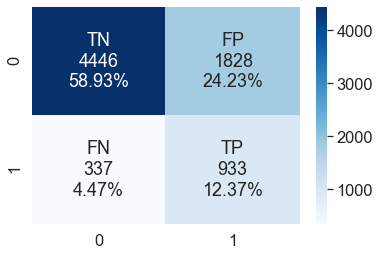

In [44]:
#Train:
train_eval(clf_LR, X_train_fs, y_train, 'Logistic Regression', 'actual')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.94      0.72      0.81      3090
           1       0.35      0.76      0.48       626

    accuracy                           0.73      3716
   macro avg       0.65      0.74      0.65      3716
weighted avg       0.84      0.73      0.76      3716
 

AUC-ROC
0.8128979393488218 

Confusion Matrix


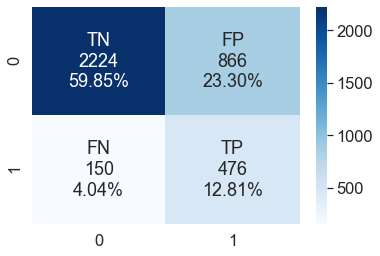

In [45]:
#Test:
test_eval(clf_LR, X_test_fs, y_test, 'Logistic Regression', 'actual')

In [46]:
y_pred = clf_LR.predict(X_train_fs)
Accuracy_Train =  accuracy_score(y_train, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_LR.predict(X_test_fs)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)


Accuracy_Train 0.713016967126193
Accuracy_Test 0.7265877287405813


### Model-2: Naïve Bayes

In [47]:
# copy of scaled datasets
X_train_sc = X_train_scaled.copy()
X_test_sc = X_test_scaled.copy()

In [48]:
clf_nb = GaussianNB()
clf_nb.fit(X_train_sc, y_train)

GaussianNB()

In [49]:
from sklearn.inspection import permutation_importance

features = ['City_Tier','CC_Contacted_LY','Payment','Gender',
        'Service_Score','Account_user_count','account_segment','CC_Agent_Score','Marital_Status','rev_per_month','Complain_ly',
        'rev_growth_yoy','coupon_used_for_payment','Day_Since_CC_connect','cashback','Login_device','Tenure_group']
imps = permutation_importance(clf_nb, X_train_sc, y_train)
importances = imps.importances_mean
std = imps.importances_std
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train_fs.shape[1]):
       print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. Complain_ly (0.054374)
2. Tenure_group (0.022004)
3. Marital_Status (0.013441)
4. CC_Agent_Score (0.008165)
5. Day_Since_CC_connect (0.006522)
6. Login_device (0.005329)
7. City_Tier (0.005329)
8. account_segment (0.005170)


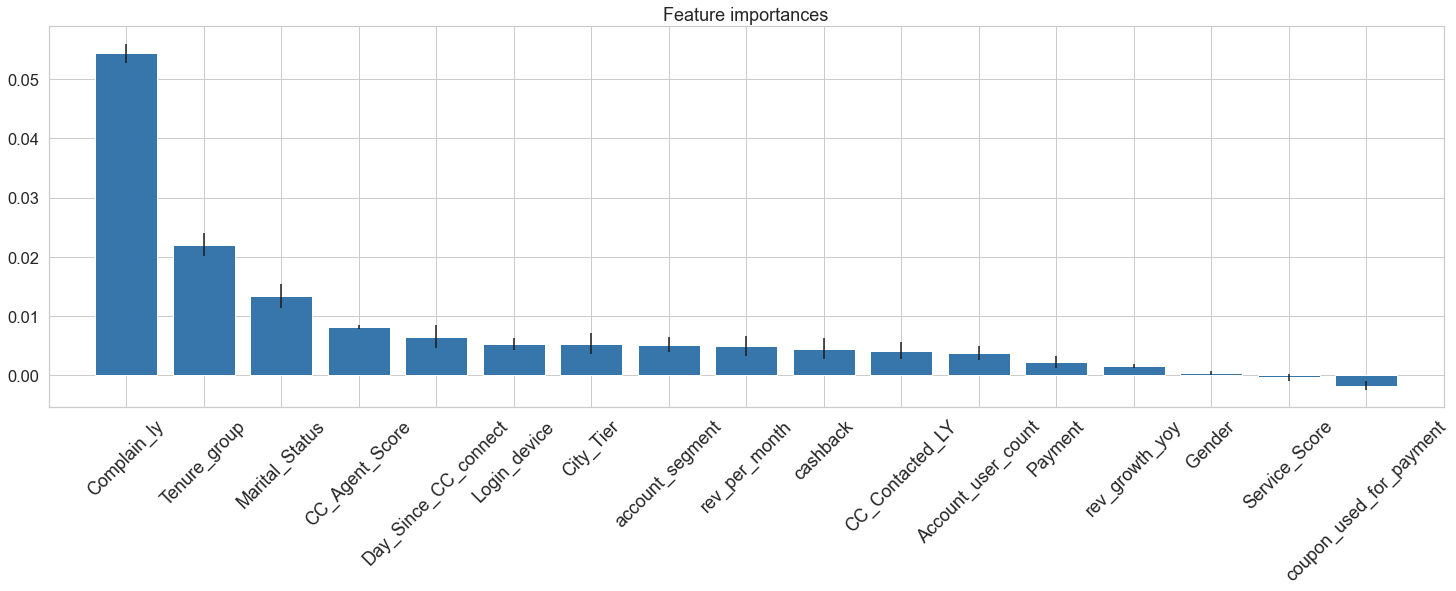

In [50]:
plt.figure(figsize=(25, 7))
plt.title("Feature importances")
plt.bar(range(X_train_sc.shape[1],), importances[indices], color="#3776ab", yerr=std[indices], align="center")
plt.xticks(range(X_train_sc.shape[1]), [features[indices[i]] for i in range(17)])
plt.xlim([-1, X_train_sc.shape[1]])
plt.xticks(rotation=45, fontsize = 18)
plt.show()

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      6274
           1       0.53      0.53      0.53      1270

    accuracy                           0.84      7544
   macro avg       0.72      0.72      0.72      7544
weighted avg       0.84      0.84      0.84      7544
 

AUC-ROC
0.7973422373048125 

Confusion Matrix


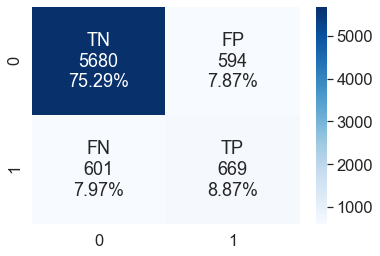

In [51]:
#Train:
train_eval(clf_nb, X_train_sc, y_train, 'Naive Bayes', 'actual')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      3090
           1       0.54      0.52      0.53       626

    accuracy                           0.84      3716
   macro avg       0.72      0.71      0.72      3716
weighted avg       0.84      0.84      0.84      3716
 

AUC-ROC
0.807516258775603 

Confusion Matrix


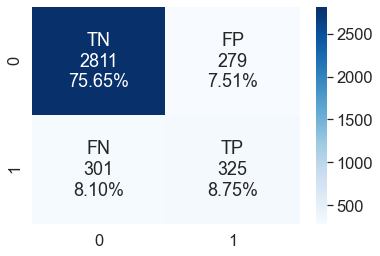

In [52]:
#Test:
test_eval(clf_nb, X_test_sc, y_test, 'Naive Bayes', 'actual')

In [53]:
y_pred = clf_nb.predict(X_train_sc)
Accuracy_Train =  accuracy_score(y_train, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_nb.predict(X_test_sc)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)

Accuracy_Train 0.8415959703075292
Accuracy_Test 0.8439181916038752


### Model-3: Stochastic Gradient Descent

In [54]:
# copy of datasets
X_train_sc = X_train_scaled.copy()
X_test_sc = X_test_scaled.copy()

In [55]:
clf_sgd = SGDClassifier(loss='modified_huber', shuffle=True, penalty = 'l1',alpha = 0.0005, random_state=123)
clf_sgd.fit(X_train_sc, y_train)

SGDClassifier(alpha=0.0005, loss='modified_huber', penalty='l1',
              random_state=123)

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      6274
           1       0.66      0.35      0.45      1270

    accuracy                           0.86      7544
   macro avg       0.77      0.66      0.69      7544
weighted avg       0.84      0.86      0.84      7544
 

AUC-ROC
0.796020572340794 

Confusion Matrix


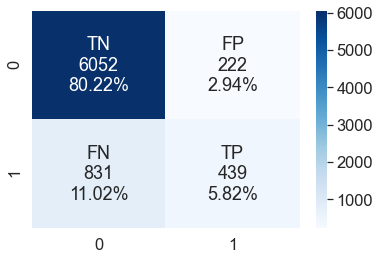

In [56]:
#Train:
train_eval(clf_sgd, X_train_sc, y_train, 'Stochastic Gradient Descent', 'actual')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      3090
           1       0.65      0.34      0.44       626

    accuracy                           0.86      3716
   macro avg       0.76      0.65      0.68      3716
weighted avg       0.84      0.86      0.84      3716
 

AUC-ROC
0.8112232079158782 

Confusion Matrix


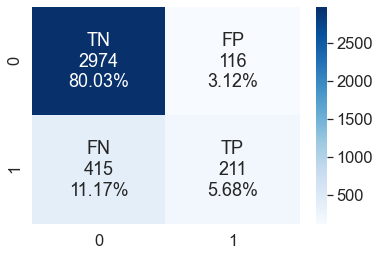

In [57]:
#Test:
test_eval(clf_sgd, X_test_sc, y_test, 'Stochastic Gradient Descent', 'actual')

In [58]:
y_pred = clf_sgd.predict(X_train_sc)
Accuracy_Train =  accuracy_score(y_train, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_sgd.predict(X_test_sc)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)


Accuracy_Train 0.8604188759278897
Accuracy_Test 0.8571044133476857


### Model-4: K-Nearest Neighbours

In [59]:
# copy of datasets
X_train_sc = X_train_scaled.copy()
X_test_sc = X_test_scaled.copy()

In [60]:
clf_knn = KNeighborsClassifier(n_neighbors = 5)
clf_knn.fit(X_train_sc, y_train)

KNeighborsClassifier()

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      6274
           1       0.90      0.62      0.73      1270

    accuracy                           0.92      7544
   macro avg       0.92      0.80      0.85      7544
weighted avg       0.92      0.92      0.92      7544
 

AUC-ROC
0.9648370101330577 

Confusion Matrix


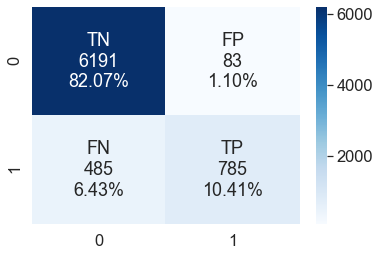

In [61]:
#Train:
train_eval(clf_knn, X_train_sc, y_train, 'K-Nearest Neighbours', 'actual')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      3090
           1       0.74      0.41      0.53       626

    accuracy                           0.88      3716
   macro avg       0.82      0.69      0.73      3716
weighted avg       0.87      0.88      0.86      3716
 

AUC-ROC
0.8554705997911431 

Confusion Matrix


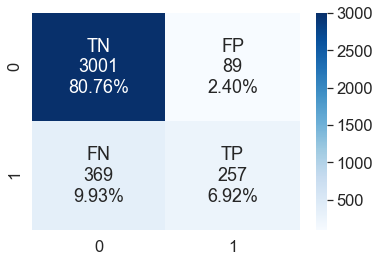

In [62]:
#Test:
test_eval(clf_knn, X_test_sc, y_test, 'K-Nearest Neighbours', 'actual')

In [63]:
y_pred = clf_knn.predict(X_train_sc)
Accuracy_Train =  accuracy_score(y_train, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_knn.predict(X_test_sc)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)


Accuracy_Train 0.9247083775185578
Accuracy_Test 0.8767491926803014


### Model-5: Decision Tree

In [64]:
# copy of scaled datasets
X_train_sc = X_train_scaled.copy()
X_test_sc = X_test_scaled.copy()

In [65]:
#Number of trees in random forest

#estimators = [2,10,30,50,100,150]
estimators = [30,50,100,300,500]

# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']

# Maximum number of depth in each tree:
max_depth = [i for i in range(5,25,2)]

# Minimum number of samples to consider to split a node:
min_samples_split = [2, 5, 10, 15, 20, 50, 100]

# Minimum number of samples to consider at each leaf node:
min_samples_leaf = [5, 4, 7]

In [66]:
tree_model = DecisionTreeClassifier()

tree_param_grid = {'max_depth': max_depth,
                   'max_features':max_features,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}

clf_DT = RandomizedSearchCV(tree_model, tree_param_grid, cv=cv, scoring='recall', random_state=123, n_jobs=-1, verbose=2)
clf_DT.fit(X_train_sc, y_train)
clf_DT = clf_DT.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [67]:
clf_DT

DecisionTreeClassifier(max_depth=23, max_features='sqrt', min_samples_leaf=4,
                       min_samples_split=10)

In [68]:
#Fitting a DecisionTreeClassifier and summarizing the calculated feature importance scores is listed below.

print (pd.DataFrame(clf_DT.feature_importances_, columns = ["Imp"], index = ['City_Tier','CC_Contacted_LY','Payment','Gender',
        'Service_Score','Account_user_count','account_segment','CC_Agent_Score','Marital_Status','rev_per_month','Complain_ly',
        'rev_growth_yoy','coupon_used_for_payment','Day_Since_CC_connect','cashback','Login_device','Tenure_group']    
    ).sort_values('Imp',ascending=False))

                              Imp
cashback                 0.103494
Complain_ly              0.099497
Day_Since_CC_connect     0.095586
CC_Agent_Score           0.088833
Tenure_group             0.084474
Marital_Status           0.077873
rev_growth_yoy           0.072608
CC_Contacted_LY          0.070685
Payment                  0.060948
rev_per_month            0.057017
Account_user_count       0.043266
account_segment          0.036504
City_Tier                0.029096
coupon_used_for_payment  0.028502
Service_Score            0.022707
Login_device             0.017269
Gender                   0.011640


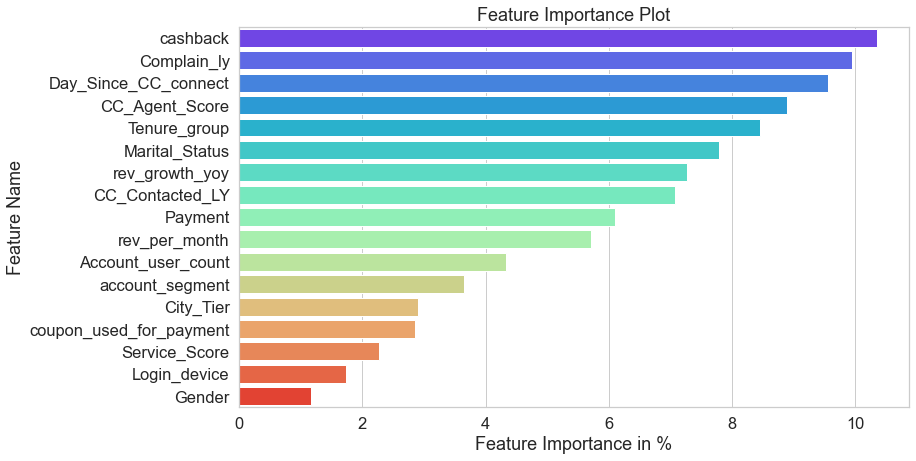

In [69]:
x=pd.DataFrame(clf_DT.feature_importances_*100,index=['City_Tier','CC_Contacted_LY','Payment','Gender',
        'Service_Score','Account_user_count','account_segment','CC_Agent_Score','Marital_Status','rev_per_month','Complain_ly',
        'rev_growth_yoy','coupon_used_for_payment','Day_Since_CC_connect','cashback','Login_device','Tenure_group']).sort_values(by=0,ascending=False)
plt.figure(figsize=(12,7))
sns.barplot(x[0], x.index, palette='rainbow')
plt.ylabel('Feature Name')
plt.xlabel('Feature Importance in %')
plt.title('Feature Importance Plot')
plt.show()

In [70]:
from sklearn.feature_selection import SelectFromModel

# Feature selection
def select_features(X_train_sc, y_train, X_test_sc):

# Select features which have higher contribution in the final prediction

    fs = SelectFromModel(clf_DT, threshold = 0.03, max_features=13) 
    
# learn relationship from training data
    fs.fit(X_train_sc, y_train)

# transform train input data
    X_train_fs = fs.transform(X_train_sc)

# transform test input data
    X_test_fs = fs.transform(X_test_sc)
    return X_train_fs, X_test_fs, fs


In [71]:
# Feature selection
X_train_fs, X_test_fs, fs = select_features(X_train_sc, y_train, X_test_sc)

In [72]:
clf_DT.fit(X_train_fs, y_train)

DecisionTreeClassifier(max_depth=23, max_features='sqrt', min_samples_leaf=4,
                       min_samples_split=10)

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      6274
           1       0.84      0.74      0.78      1270

    accuracy                           0.93      7544
   macro avg       0.89      0.85      0.87      7544
weighted avg       0.93      0.93      0.93      7544
 

AUC-ROC
0.9785947630390639 

Confusion Matrix


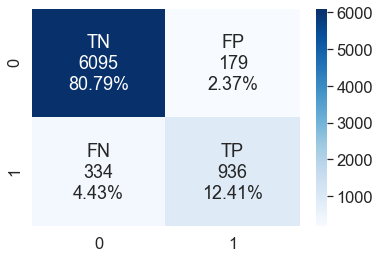

In [73]:
#Train: 
train_eval(clf_DT, X_train_fs, y_train, 'Decision Tree', 'actual')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      3090
           1       0.64      0.56      0.59       626

    accuracy                           0.87      3716
   macro avg       0.77      0.75      0.76      3716
weighted avg       0.87      0.87      0.87      3716
 

AUC-ROC
0.846337510468687 

Confusion Matrix


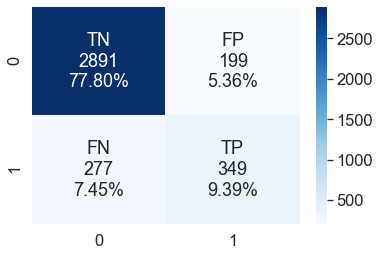

In [74]:
#Test:
test_eval(clf_DT, X_test_fs, y_test, 'Decision Tree', 'actual')

In [75]:
y_pred = clf_DT.predict(X_train_fs)
Accuracy_Train =  accuracy_score(y_train, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_DT.predict(X_test_fs)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)


Accuracy_Train 0.931998939554613
Accuracy_Test 0.8719052744886975


### Model-6: Random Forest

In [76]:
# copy of scaled datasets
X_train_sc = X_train_scaled.copy()
X_test_sc = X_test_scaled.copy()

In [77]:
rf_model = RandomForestClassifier()

rf_params={'n_estimators':estimators,
           'max_features':max_features,
           'max_depth':max_depth,
           'min_samples_leaf': min_samples_leaf,
           'min_samples_split':min_samples_split}

cv = StratifiedKFold(n_splits=5)

clf_RF = RandomizedSearchCV(rf_model, rf_params, cv=cv, scoring='recall', n_jobs=-1, random_state=123, n_iter=20, verbose=2)
clf_RF.fit(X_train_sc, y_train)
clf_RF = clf_RF.best_estimator_


Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [78]:
clf_RF 

RandomForestClassifier(max_depth=23, max_features='log2', min_samples_leaf=4,
                       min_samples_split=5, n_estimators=500)

In [79]:
#Fitting a RandomForestClassifier and summarizing the calculated feature importance scores is listed below.

print (pd.DataFrame(clf_RF.feature_importances_, columns = ["Imp"], index = ['City_Tier','CC_Contacted_LY','Payment','Gender',
        'Service_Score','Account_user_count','account_segment','CC_Agent_Score','Marital_Status','rev_per_month','Complain_ly',
        'rev_growth_yoy','coupon_used_for_payment','Day_Since_CC_connect','cashback','Login_device','Tenure_group']    
    ).sort_values('Imp',ascending=False))

                              Imp
cashback                 0.113712
Complain_ly              0.104388
Day_Since_CC_connect     0.090306
CC_Contacted_LY          0.087353
rev_growth_yoy           0.074238
CC_Agent_Score           0.072857
Tenure_group             0.062743
rev_per_month            0.061111
Marital_Status           0.057824
Payment                  0.054184
account_segment          0.054095
Account_user_count       0.039485
City_Tier                0.034796
coupon_used_for_payment  0.027417
Gender                   0.023625
Service_Score            0.021609
Login_device             0.020256


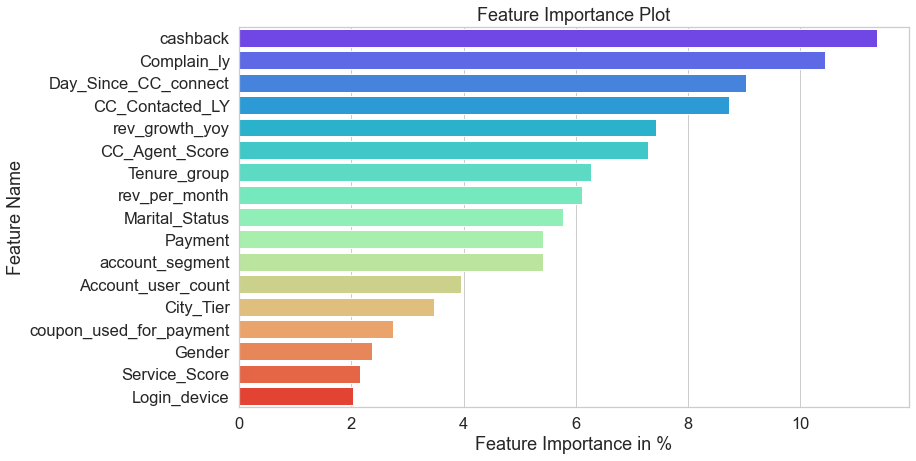

In [80]:
x=pd.DataFrame(clf_RF.feature_importances_*100,index=['City_Tier','CC_Contacted_LY','Payment','Gender',
        'Service_Score','Account_user_count','account_segment','CC_Agent_Score','Marital_Status','rev_per_month','Complain_ly',
        'rev_growth_yoy','coupon_used_for_payment','Day_Since_CC_connect','cashback','Login_device','Tenure_group']).sort_values(by=0,ascending=False)
plt.figure(figsize=(12,7))
sns.barplot(x[0], x.index, palette='rainbow')
plt.ylabel('Feature Name')
plt.xlabel('Feature Importance in %')
plt.title('Feature Importance Plot')
plt.show()

In [81]:
from sklearn.feature_selection import SelectFromModel

# Feature selection
def select_features(X_train_scaled, y_train, X_test_scaled):

# Select features which have higher contribution in the final prediction

    fs = SelectFromModel(clf_RF, threshold = 0.03, max_features=13) 
    
# learn relationship from training data
    fs.fit(X_train_sc, y_train)

# transform train input data
    X_train_fs = fs.transform(X_train_sc)

# transform test input data
    X_test_fs = fs.transform(X_test_sc)
    return X_train_fs, X_test_fs, fs


In [82]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train_sc, y_train, X_test_sc)

In [83]:
print(X_train.columns[fs.get_support()])
print(X_test.columns[fs.get_support()])

Index(['City_Tier', 'CC_Contacted_LY', 'Payment', 'Account_user_count',
       'account_segment', 'CC_Agent_Score', 'Marital_Status', 'rev_per_month',
       'Complain_ly', 'rev_growth_yoy', 'Day_Since_CC_connect', 'cashback',
       'Tenure_group'],
      dtype='object')
Index(['City_Tier', 'CC_Contacted_LY', 'Payment', 'Account_user_count',
       'account_segment', 'CC_Agent_Score', 'Marital_Status', 'rev_per_month',
       'Complain_ly', 'rev_growth_yoy', 'Day_Since_CC_connect', 'cashback',
       'Tenure_group'],
      dtype='object')


In [84]:
clf_RF.fit(X_train_fs, y_train)

RandomForestClassifier(max_depth=23, max_features='log2', min_samples_leaf=4,
                       min_samples_split=5, n_estimators=500)

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      6274
           1       0.99      0.79      0.88      1270

    accuracy                           0.96      7544
   macro avg       0.98      0.89      0.93      7544
weighted avg       0.96      0.96      0.96      7544
 

AUC-ROC
0.9977772283564968 

Confusion Matrix


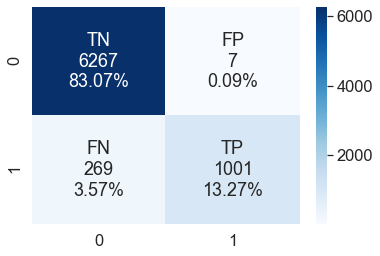

In [85]:
#Train:
train_eval(clf_RF, X_train_fs, y_train, 'Random Forest', 'actual')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      3090
           1       0.94      0.53      0.68       626

    accuracy                           0.92      3716
   macro avg       0.93      0.76      0.82      3716
weighted avg       0.92      0.92      0.91      3716
 

AUC-ROC
0.9658824198434609 

Confusion Matrix


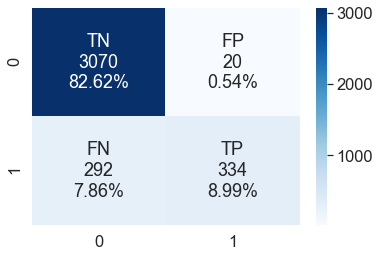

In [86]:
#Test:
test_eval(clf_RF, X_test_fs, y_test, 'Random Forest', 'actual')

In [87]:
y_pred = clf_RF.predict(X_train_fs)
Accuracy_Train =  accuracy_score(y_train, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_RF.predict(X_test_fs)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)

Accuracy_Train 0.9634146341463414
Accuracy_Test 0.9160387513455328


### Model Comparision for imbalanced data

In [88]:
clf_eval_df = pd.DataFrame({'Model':model,
                            'Dataset':dataset,
                            'Resample':resample,
                            'Precision':precision,
                            'Recall':recall,
                            'f1-score':F1score,
                            'Accuracy':Accuracy,
                            'AUC-ROC':AUCROC})

In [89]:
cm = sns.light_palette("green", as_cmap = True)
s = clf_eval_df.style.background_gradient(cmap=cm)
s

,Model,Dataset,Resample,Precision,Recall,f1-score,Accuracy,AUC-ROC
0,Logistic Regression,train,actual,0.337921,0.734646,0.462912,0.713017,0.797788
1,Logistic Regression,test,actual,0.354694,0.760383,0.483740,0.726588,0.812898
2,Naive Bayes,train,actual,0.529691,0.526772,0.528227,0.841596,0.797342
3,Naive Bayes,test,actual,0.538079,0.519169,0.528455,0.843918,0.807516
4,Stochastic Gradient Descent,train,actual,0.664145,0.345669,0.454687,0.860419,0.796021
5,Stochastic Gradient Descent,test,actual,0.645260,0.337061,0.442812,0.857104,0.811223
6,K-Nearest Neighbours,train,actual,0.904378,0.618110,0.734331,0.924708,0.964837
7,K-Nearest Neighbours,test,actual,0.742775,0.410543,0.528807,0.876749,0.855471
8,Decision Tree,train,actual,0.839462,0.737008,0.784906,0.931999,0.978595
9,Decision Tree,test,actual,0.636861,0.557508,0.594549,0.871905,0.846338


### SMOTE:

In [136]:
# copy of datasets
X_train_sc = X_train_scaled.copy()
X_test_sc = X_test_scaled.copy()

In [137]:
from imblearn.over_sampling import SMOTE
from collections import Counter

counter = Counter(y_train)
print('Before',counter)

# oversampling the train dataset using SMOTE
smt = SMOTE(random_state = 123)

#X_train, y_train = smt.fit_resample(X_train, y_train)
X_train_smote, y_train_smote = smt.fit_resample(X_train_sc, y_train.ravel())

counter = Counter(y_train_smote)
print('After',counter)

print('\nAfter OverSampling, the shape of X_train: {}'.format(X_train_smote.shape))
print('After OverSampling, the shape of y_train: {} \n'.format(y_train_smote.shape))

Before Counter({0: 6274, 1: 1270})
After Counter({0: 6274, 1: 6274})

After OverSampling, the shape of X_train: (12548, 17)
After OverSampling, the shape of y_train: (12548,) 



In [138]:
# copy of datasets
X_train_fs = X_train_smote.copy()
y_train_fs = y_train_smote.copy()

In [139]:
model = list()
dataset = list()
resample = list()
precision = list()
recall = list()
F1score = list()
Accuracy = list()
AUCROC = list()

In [140]:
def train_eval(clf_model, X_train_sm, y_train_sm, algo=None, sampling=None):
    
    # Test set prediction
    y_prob=clf_model.predict_proba(X_train_sm)
    y_pred=clf_model.predict(X_train_sm)

    print('Classification Report for Train dataset')
    print('='*60)
    print(classification_report(y_train_sm,y_pred),"\n")
    print('AUC-ROC')
    print('='*60)
    print(roc_auc_score(y_train_sm, y_prob[:,1]),"\n")
    
    print('Confusion Matrix')
    print('='*60)
    cf_matrix = confusion_matrix(y_train_sm, y_pred)
    group_names = ['TN','FP','FN','TP']
    group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
          
    model.append(algo)
    precision.append(precision_score(y_train_sm,y_pred))
    recall.append(recall_score(y_train_sm,y_pred))
    F1score.append(f1_score(y_train_sm,y_pred))
    Accuracy.append(accuracy_score(y_train_sm, y_pred))
    AUCROC.append(roc_auc_score(y_train_sm, y_prob[:,1]))
    dataset.append('train')
    resample.append(sampling)
   

In [141]:
def test_eval(clf_model, X_test_scaled, y_test, algo=None, sampling=None):
    
    # Test set prediction
    y_prob=clf_model.predict_proba(X_test_scaled)
    y_pred=clf_model.predict(X_test_scaled)

    print('Classification Report for Test dataset')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    print('AUC-ROC')
    print('='*60)
    print(roc_auc_score(y_test, y_prob[:,1]),"\n")
    
    print('Confusion Matrix')
    print('='*60)
    cf_matrix = confusion_matrix(y_test, y_pred)
    group_names = ['TN','FP','FN','TP']
    group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
          
    model.append(algo)
    precision.append(precision_score(y_test,y_pred))
    recall.append(recall_score(y_test,y_pred))
    F1score.append(f1_score(y_test,y_pred))
    Accuracy.append(accuracy_score(y_test, y_pred))
    AUCROC.append(roc_auc_score(y_test, y_prob[:,1]))
    dataset.append('test')
    resample.append(sampling)

In [142]:
# Oversampling the train dataset using SMOTE
smt = SMOTE(random_state = 123)

#X_train, y_train = smt.fit_resample(X_train, y_train)
X_train_sm, y_train_sm = smt.fit_resample(X_train_scaled, y_train.ravel())

### Model-1: Logistic Regression - SMOTE Resampling

In [143]:
# copy of smote datasets
X_train_fs = X_train_smote.copy()
y_train_fs = y_train_smote.copy()

In [144]:
clf_LR

LogisticRegression(C=1048.1131341546863, class_weight='balanced')

In [145]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train_scaled, y_train, X_test_scaled)

In [146]:
# Oversampling the train dataset using SMOTE
smt = SMOTE(random_state = 123)

#X_train, y_train = smt.fit_resample(X_train, y_train)
X_train_sm, y_train_sm = smt.fit_resample(X_train_fs, y_train.ravel())

In [147]:
clf_LR.fit(X_train_sm, y_train_sm)

LogisticRegression(C=1048.1131341546863, class_weight='balanced')

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.77      0.73      0.75      6274
           1       0.74      0.79      0.76      6274

    accuracy                           0.76     12548
   macro avg       0.76      0.76      0.76     12548
weighted avg       0.76      0.76      0.76     12548
 

AUC-ROC
0.8269458159214995 

Confusion Matrix


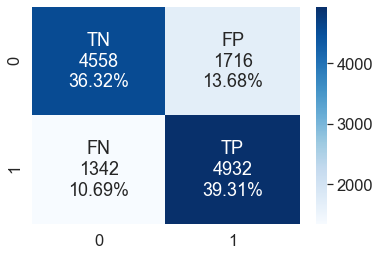

In [148]:
#Train:
train_eval(clf_LR, X_train_sm, y_train_sm, 'Logistic Regression', 'smote')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.94      0.74      0.83      3090
           1       0.37      0.78      0.50       626

    accuracy                           0.74      3716
   macro avg       0.66      0.76      0.67      3716
weighted avg       0.85      0.74      0.77      3716
 

AUC-ROC
0.8303436831167219 

Confusion Matrix


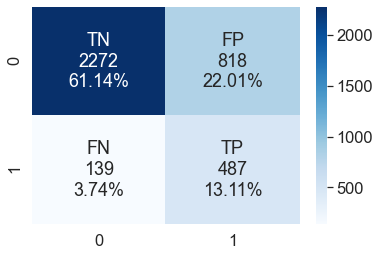

In [149]:
#Test:
test_eval(clf_LR, X_test_fs, y_test, 'Logistic Regression', 'smote')

In [150]:
y_pred = clf_LR.predict(X_train_sm)
Accuracy_Train =  accuracy_score(y_train_sm, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_LR.predict(X_test_fs)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)


Accuracy_Train 0.756295824035703
Accuracy_Test 0.7424650161463939


### Model-2: Naïve Bayes - SMOTE Resampling

In [151]:
#X_train, y_train = smt.fit_resample(X_train, y_train)
X_train_sm, y_train_sm = smt.fit_resample(X_train_scaled, y_train.ravel())

In [152]:
clf_nb.fit(X_train_sm, y_train_sm)

GaussianNB()

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.75      0.59      0.66      6274
           1       0.66      0.81      0.73      6274

    accuracy                           0.70     12548
   macro avg       0.71      0.70      0.69     12548
weighted avg       0.71      0.70      0.69     12548
 

AUC-ROC
0.810179925979362 

Confusion Matrix


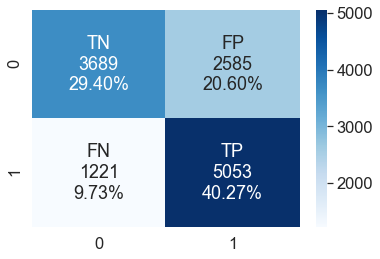

In [153]:
# Train:
train_eval(clf_nb, X_train_sm, y_train_sm, 'Naive Bayes', 'smote')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.93      0.62      0.75      3090
           1       0.29      0.77      0.42       626

    accuracy                           0.65      3716
   macro avg       0.61      0.70      0.58      3716
weighted avg       0.82      0.65      0.69      3716
 

AUC-ROC
0.7919921006648263 

Confusion Matrix


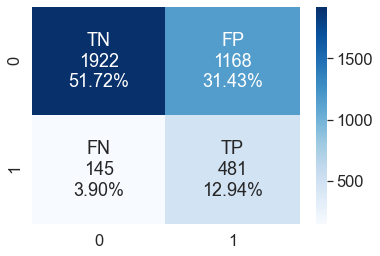

In [154]:
#Test:
test_eval(clf_nb, X_test_scaled, y_test, 'Naive Bayes', 'smote')

In [155]:
y_pred = clf_nb.predict(X_train_sm)
Accuracy_Train =  accuracy_score(y_train_sm, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_nb.predict(X_test_scaled)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)

Accuracy_Train 0.6966847306343641
Accuracy_Test 0.6466630785791173


### Model-3: Stochastic Gradient Descent - SMOTE Resampling

In [156]:
#X_train, y_train = smt.fit_resample(X_train, y_train)
X_train_sm, y_train_sm = smt.fit_resample(X_train_scaled, y_train.ravel())

In [157]:
clf_sgd.fit(X_train_sm, y_train_sm)

SGDClassifier(alpha=0.0005, loss='modified_huber', penalty='l1',
              random_state=123)

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.78      0.73      0.75      6274
           1       0.75      0.79      0.77      6274

    accuracy                           0.76     12548
   macro avg       0.76      0.76      0.76     12548
weighted avg       0.76      0.76      0.76     12548
 

AUC-ROC
0.7614034025186447 

Confusion Matrix


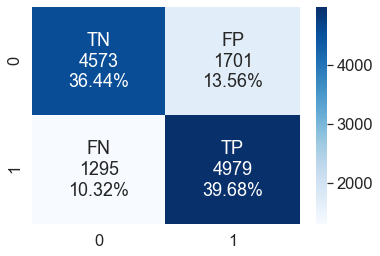

In [158]:
#Train:
train_eval(clf_sgd, X_train_sm, y_train_sm, 'Stochastic Gradient Descent', 'smote')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.94      0.73      0.82      3090
           1       0.37      0.78      0.50       626

    accuracy                           0.74      3716
   macro avg       0.66      0.76      0.66      3716
weighted avg       0.85      0.74      0.77      3716
 

AUC-ROC
0.7555005841785829 

Confusion Matrix


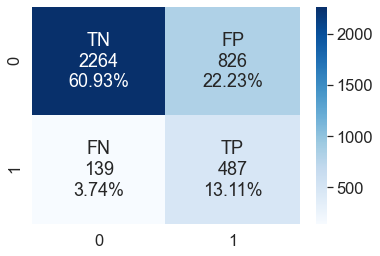

In [159]:
#Test:
test_eval(clf_sgd, X_test_scaled, y_test, 'Stochastic Gradient Descent', 'smote')

In [160]:
y_pred = clf_sgd.predict(X_train_sm)
Accuracy_Train =  accuracy_score(y_train_sm, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_sgd.predict(X_test_scaled)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)

Accuracy_Train 0.7612368504941026
Accuracy_Test 0.7403121636167922


### Model-4: K-Nearest Neighbours - SMOTE Resampling

In [161]:
# copy of datasets
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

#X_train, y_train = smt.fit_resample(X_train, y_train)
X_train_sm, y_train_sm = smt.fit_resample(X_train_scaled, y_train.ravel())

In [162]:
clf_knn.fit(X_train_sm, y_train_sm)

KNeighborsClassifier()

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.99      0.82      0.90      6274
           1       0.84      1.00      0.91      6274

    accuracy                           0.91     12548
   macro avg       0.92      0.91      0.91     12548
weighted avg       0.92      0.91      0.91     12548
 

AUC-ROC
0.9965235948532072 

Confusion Matrix


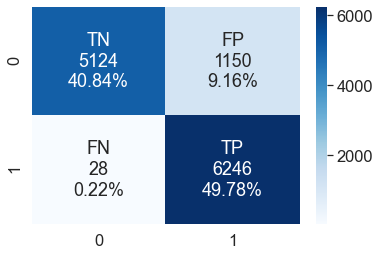

In [163]:
#Train:
train_eval(clf_knn, X_train_sm, y_train_sm, 'K-Nearest Neighbours', 'smote')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.94      0.74      0.83      3090
           1       0.37      0.75      0.50       626

    accuracy                           0.74      3716
   macro avg       0.65      0.75      0.66      3716
weighted avg       0.84      0.74      0.77      3716
 

AUC-ROC
0.8124140533722096 

Confusion Matrix


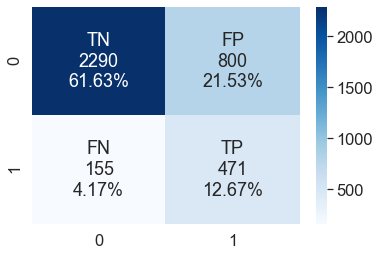

In [164]:
#Test:
test_eval(clf_knn, X_test_scaled, y_test, 'K-Nearest Neighbours', 'smote')

In [165]:
y_pred = clf_knn.predict(X_train_sm)
Accuracy_Train =  accuracy_score(y_train_sm, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_knn.predict(X_test_scaled)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)

Accuracy_Train 0.9061204972904049
Accuracy_Test 0.7430032292787944


### Model-5: Decision Tree - SMOTE Resampling

In [166]:
# copy of datasets
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

In [167]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train_scaled, y_train, X_test_scaled)

In [168]:
# oversampling the train dataset using SMOTE
smt = SMOTE(random_state = 123)

#X_train, y_train = smt.fit_resample(X_train, y_train)
X_train_sm, y_train_sm = smt.fit_resample(X_train_fs, y_train.ravel())

In [169]:
clf_DT.fit(X_train_sm, y_train_sm)

DecisionTreeClassifier(max_depth=23, max_features='sqrt', min_samples_leaf=4,
                       min_samples_split=10)

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      6274
           1       0.97      0.93      0.95      6274

    accuracy                           0.95     12548
   macro avg       0.95      0.95      0.95     12548
weighted avg       0.95      0.95      0.95     12548
 

AUC-ROC
0.9938263589969443 

Confusion Matrix


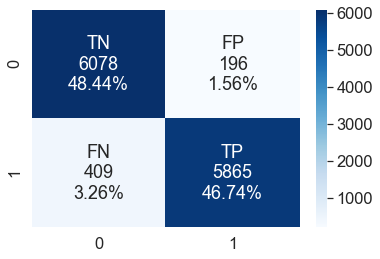

In [170]:
#Train:

train_eval(clf_DT, X_train_sm, y_train_sm, 'Decision Tree', 'smote')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      3090
           1       0.65      0.58      0.61       626

    accuracy                           0.88      3716
   macro avg       0.79      0.76      0.77      3716
weighted avg       0.87      0.88      0.87      3716
 

AUC-ROC
0.8568966675972167 

Confusion Matrix


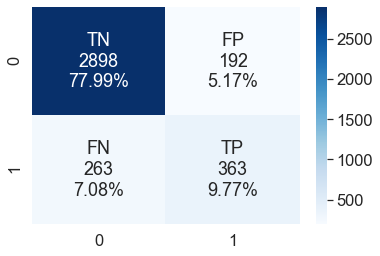

In [171]:
#Test:
test_eval(clf_DT, X_test_fs, y_test, 'Decision Tree', 'smote')

In [172]:
y_pred = clf_DT.predict(X_train_sm)
Accuracy_Train =  accuracy_score(y_train_sm, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_DT.predict(X_test_fs)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)

Accuracy_Train 0.9517851450430348
Accuracy_Test 0.8775565123789021


### Model-6: Random Forest - SMOTE Resampling

In [173]:
# copy of datasets
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

In [174]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train_scaled, y_train, X_test_scaled)

In [175]:
# oversampling the train dataset using SMOTE
smt = SMOTE(random_state = 123)

#X_train, y_train = smt.fit_resample(X_train, y_train)
X_train_sm, y_train_sm = smt.fit_resample(X_train_fs, y_train.ravel())

In [176]:
clf_RF.fit(X_train_sm, y_train_sm)

RandomForestClassifier(max_depth=23, max_features='log2', min_samples_leaf=4,
                       min_samples_split=5, n_estimators=500)

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6274
           1       0.99      0.98      0.99      6274

    accuracy                           0.99     12548
   macro avg       0.99      0.99      0.99     12548
weighted avg       0.99      0.99      0.99     12548
 

AUC-ROC
0.9994647521956871 

Confusion Matrix


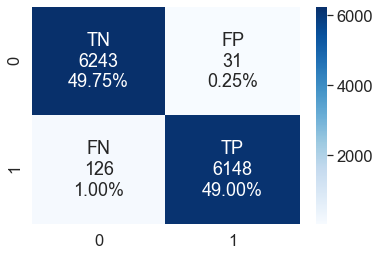

In [177]:
#Train:
train_eval(clf_RF, X_train_sm, y_train_sm, 'Random Forest', 'smote')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      3090
           1       0.85      0.68      0.75       626

    accuracy                           0.93      3716
   macro avg       0.89      0.83      0.86      3716
weighted avg       0.92      0.93      0.92      3716
 

AUC-ROC
0.9627030408304641 

Confusion Matrix


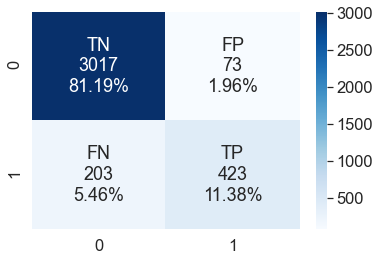

In [178]:
#Test:
test_eval(clf_RF, X_test_fs, y_test, 'Random Forest', 'smote')

In [179]:
y_pred = clf_RF.predict(X_train_sm)
Accuracy_Train =  accuracy_score(y_train_sm, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_RF.predict(X_test_fs)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)


Accuracy_Train 0.9874880459037296
Accuracy_Test 0.9257265877287406


### Model Comparision for balanced data

In [180]:
clf_eval_df2 = pd.DataFrame({'Model':model,
                            'Dataset':dataset,
                            'Resample':resample,
                            'Precision':precision,
                            'Recall':recall,
                            'f1-score':F1score,
                            'Accuracy':Accuracy,
                            'AUC-ROC':AUCROC})

In [181]:
cm = sns.light_palette("green", as_cmap = True)
s = clf_eval_df2.style.background_gradient(cmap=cm)
s

,Model,Dataset,Resample,Precision,Recall,f1-score,Accuracy,AUC-ROC
0,Logistic Regression,train,smote,0.741877,0.786101,0.763349,0.756296,0.826946
1,Logistic Regression,test,smote,0.373180,0.777955,0.504402,0.742465,0.830344
2,Naive Bayes,train,smote,0.661561,0.805387,0.726423,0.696685,0.810180
3,Naive Bayes,test,smote,0.291692,0.768371,0.422857,0.646663,0.791992
4,Stochastic Gradient Descent,train,smote,0.745359,0.793593,0.768720,0.761237,0.761403
5,Stochastic Gradient Descent,test,smote,0.370906,0.777955,0.502321,0.740312,0.755501
6,K-Nearest Neighbours,train,smote,0.844511,0.995537,0.913826,0.906120,0.996524
7,K-Nearest Neighbours,test,smote,0.370574,0.752396,0.496574,0.743003,0.812414
8,Decision Tree,train,smote,0.967662,0.934810,0.950953,0.951785,0.993826
9,Decision Tree,test,smote,0.654054,0.579872,0.614733,0.877557,0.856897
